In [3]:
!pip install cartopy
import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 84.3 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8496 - loss: 0.2933 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 4.5497e-04
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 3.7373e-04 - val_accuracy: 1.0000 - val_loss: 1.8509e-04
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.6224e-04 - val_accuracy: 1.0000 - val_loss: 9.5839e-05
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 8.6503e-05 - val_accuracy: 1.0000 - val_loss: 5.6512e-05
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 5.0413e-05 - val_accuracy: 1.0000 - val_loss: 3.5957e-05
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.3339e-05 - val_accuracy: 1.0000 - val_loss: 2.4046e-05
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accur

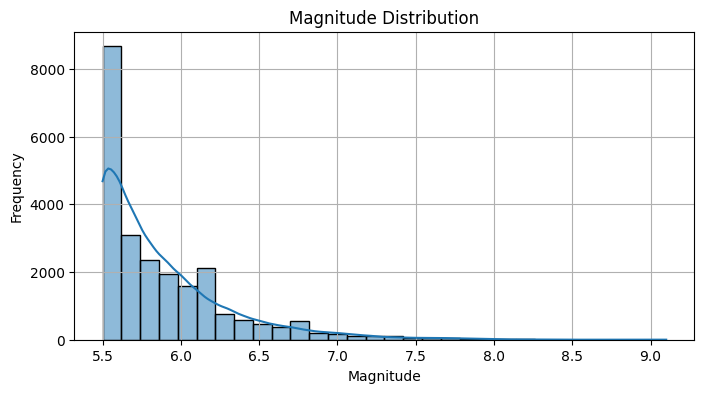

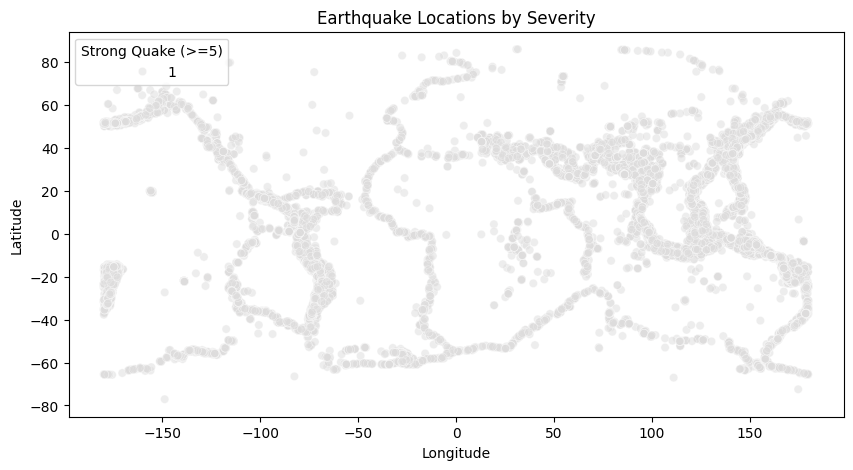

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


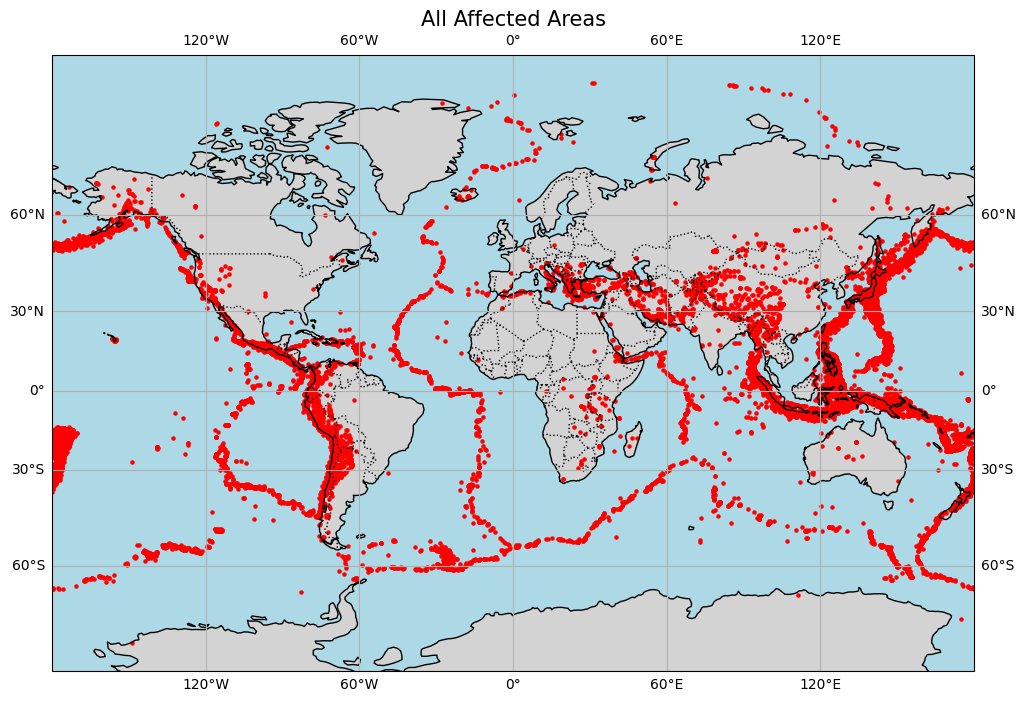

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Load dataset
df = pd.read_csv("database.csv")

# Step 1: Combine and convert 'Date' + 'Time' to Unix timestamp
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
df['Timestamp'] = df['Datetime'].astype(np.int64) // 10**9
df.dropna(subset=['Timestamp', 'Latitude', 'Longitude', 'Depth', 'Magnitude'], inplace=True)

# Step 2: Feature selection
features = ['Latitude', 'Longitude', 'Depth', 'Magnitude']
X = df[features]

# Step 3: Create binary labels: 1 if Magnitude >= 5, else 0
df['Label'] = (df['Magnitude'] >= 5.0).astype(int)
y = to_categorical(df['Label'], num_classes=2)

# Step 4: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 6: Build model
model = Sequential([
    Dense(16, input_shape=(4,), activation='relu'),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 7: Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Step 8: Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.3f}")

# Step 9: Visualization - Magnitude Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['Magnitude'], bins=30, kde=True)
plt.title('Magnitude Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Step 10: Visualization - Scatterplot of locations
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Label', palette='coolwarm', alpha=0.5)
plt.title("Earthquake Locations by Severity")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Strong Quake (>=5)')
plt.show()

# Step 11: Cartopy World Map - Earthquake Points
plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.set_title("All Affected Areas", fontsize=15)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

ax.scatter(df['Longitude'], df['Latitude'], color='red', s=5, transform=ccrs.PlateCarree())
plt.show()
